# Magnitudes

We commonly describe an earthquakes size based on it's magnitude. There are various magnitude scales in use, but all
vary logarithmically. In a general sense, the energy released by a magnitude 2 earthquake is ten times greater than a 
magnitude 1. However, most magnitude scales are not perfectly related to energy, only the moment magnitude ($M_W$) scale
is tied directly to energy release.

In this notebook we will look at how the following magnitudes are calculated:
- Local Magnitude ($M_L$;
- Coda-duration Magnitude ($M_D$);
- Moment Magnitude ($M_W$);
- W-phase derived Moment Magnitude ($M_{WW}$).

The theory behind most of this can be found in Section 4.6 of Stein and Wysession. For more information on the W-phase
moment magnitude method (which is now routinely in use by USGS for fast determination of large earthquake magnitudes),
see [Duputel et al., 2012](https://academic.oup.com/gji/article/189/2/1125/621962).

For a list of other commonly used scales, see the [USGS table of magnitude.](https://earthquake.usgs.gov/learn/topics/mag-intensity/magnitude-types.php)

## Local Magnitude

$M_L$ began life as the *Richter magnitude*, however, this is a magnitude scale with specific scaling parameters for Southern
California. The same equation form used in the initial Richter scale is used elsewhere, but with appropriate attenuation
parameters: if the Richter scale is used in New Zealand it doesn't give the correct result (as well will see when we try to use it!).

$M_L$ is based on the measurement of the peak amplitude in a waveform recorded by a *Wood-Anderson* seismometer. There are
very few Wood-Anderson seismometers still in operation today, but we know what the instrument response of a Wood-Anderson
instrument is, and can therefore simulate Wood-Anderson waveforms from other instruments.  The original Richter local magnitude
scale is:

\begin{equation*}
    M_L = \log{A} + 2.76\log{\Delta} - 2.48
\end{equation*}
where $A$ is the peak amplitude (in micro-meters) on a Wood-Anderson seismometer, $\Delta$ is the epicentral distance. This only works
well for shallow earthquakes. The second term effectively corrects for geometrical spreading, while the final factor
is included to scale the magnitude.

The adapted local magnitude scale for New Zealand is:
\begin{equation*}
    M_L = \log{A} + \log{\Delta} + 0.0029\Delta + S
\end{equation*}
where S is a station correction term. See [Ristau, 2009](https://pubs.geoscienceworld.org/ssa/bssa/article/99/3/1841/342119/comparison-of-magnitude-estimates-for-new-zealand)
for a discussion of some of the magnitudes in use in New Zealand.

Recent work by [Michailos et al., 2019](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2018GC007743) derived
a robust local magnitude scale for the Southern Alps tied to moment magnitude:

\begin{equation*}
    M_L = \log{A} + \log{r} + \eta r - S - 3.644
\end{equation*}
where $r$ is the hypocentral distance, $\eta$ is an attenuation parameter, which, for $r\le 60km$ is $1.2\times 10^{-2}km^{-1}$
and for $r>60km$ is $0.01\times 10^{-2}km{-1}$. $S$ is a site dependent correction which incorporate local site effects. Geometrical
spreading is assumed to be logarithmically related to $r$, with a gradient of 1.

Lets look at how we would pick an amplitude for local magnitude for a nearby earthquake. We will use the `seismic_picker.py` applet again
which has been extended to allow amplitude and duration picks to be made:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from obspy.clients.fdsn import Client

client = Client("GEONET")
event = client.get_events(eventid="2019p304574")[0]
# Lets just use the closest five weak motion stations
clean_event = event.copy()
clean_event.amplitudes = []
clean_event.station_magnitudes = []
clean_event.picks = [
    p for p in sorted(event.picks, key=lambda p: p.time) 
    if p.waveform_id.channel_code[0] != "B"][0:5]

bulk = [
    (p.waveform_id.network_code, p.waveform_id.station_code, 
     p.waveform_id.location_code, p.waveform_id.channel_code[0:-1] + "?", 
     p.time - 60, p.time + 200) for p in clean_event.picks]
st = client.get_waveforms_bulk(bulk)

# We need to response information for the stations so that we can correct
# the repsonse and simulate a wood anderson instrument.
inv = client.get_stations_bulk(bulk, level="response")

To pick local magnitudes we want to simulate a Wood-Anderson instrument.  To do this we can use obspy's 
[remove_response](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.remove_response.html#obspy.core.stream.Stream.remove_response)
and [simulate](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.simulate.html#obspy.core.stream.Stream.simulate) 
methods to remove the instrument response then apply the Wood-Anderson response.

In [2]:
paz_WA = {'poles': [-6.283 + 4.7124j, -6.283 - 4.7124j],
          'zeros': [0 + 0j], 'gain': 1.0, 'sensitivity': 2080}
st_wa = st.copy()
st_wa = st_wa.remove_response(inv, "DISP")
st_wa = st_wa.simulate(paz_remove=None, paz_simulate=paz_WA)

/home/calumch/miniconda3/envs/gphs445/lib/python3.7/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


You will have to re-run the above in an interactive Python session to use the picke. Then run the picker. Amplitude picks for
local magnitudes are commonly picked on the vertical channel - they were originally defined as being picked on the
horizontals, but verticals are more common because they are less succeptible to shallow amplification effects. Picks
should be made at the maximum amplitude.  The picker will record your mouse position and add an `Amplitude` and a `Pick`
for that position.

Make your picks using:
	left mouse button: P
	right mouse button: S
	'a': amplitude at mouse location
	'e': end duration at mouse location - needs a P-pick to calculate duration
	P-wave polarity can be picked using the up and down arrows while hovering over a P-pick.

Picks can be deleted by hovering over them and pressing the middle mouse button


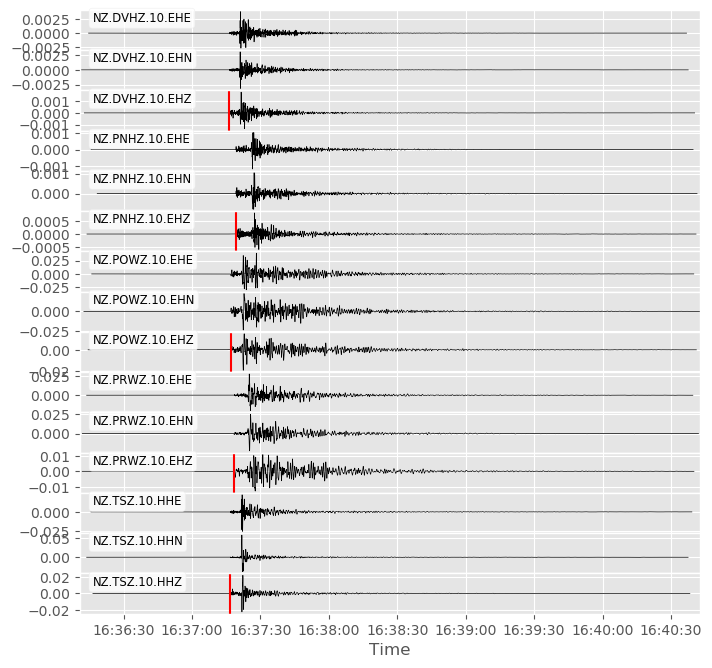

In [3]:
from seismic_picker import seismic_picker

event_out = seismic_picker(st_wa, event_in=clean_event)

The file `magnitude_picked.xml` contains the picks I made. Lets use those to calculate a magnitude. You can replace this with
the picks you made (write then out by running `event_out.write("my_picked_event.xml", format="QUAKEML")`.

Make your picks using:
	left mouse button: P
	right mouse button: S
	'a': amplitude at mouse location
	'e': end duration at mouse location - needs a P-pick to calculate duration
	P-wave polarity can be picked using the up and down arrows while hovering over a P-pick.

Picks can be deleted by hovering over them and pressing the middle mouse button


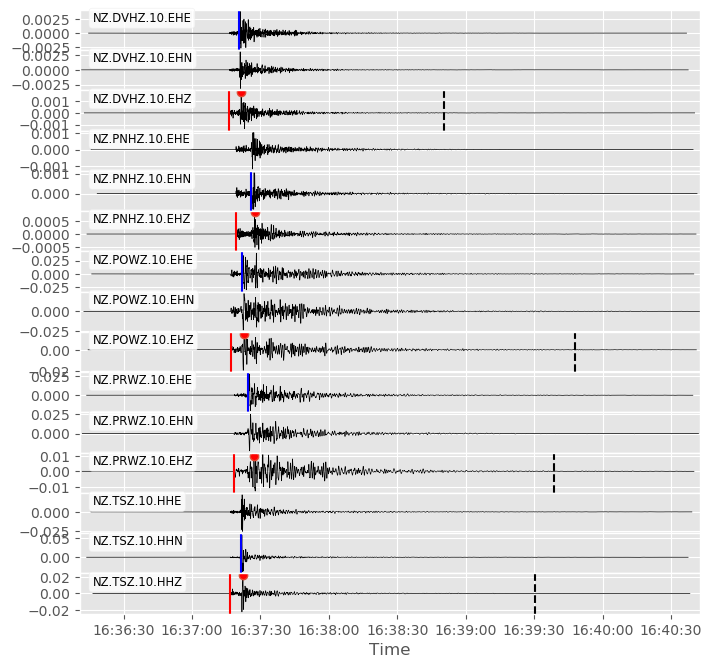

Duration: 93.9198s
Duration: 151.0206s
Duration: 140.2494s
Duration: 133.4403s


In [4]:
from obspy import read_events

event_picked = read_events("magnitude_picked.xml")[0]
# Quick plot to check that the picks are recorded in the right place
_ = seismic_picker(st_wa, event_picked)

In [5]:
for amplitude in event_picked.amplitudes:
    if amplitude.type != "END":
        print("Amplitude: {0:.2g} m".format(amplitude.generic_amplitude))

Amplitude: 0.0018 m
Amplitude: 0.00085 m
Amplitude: 0.015 m
Amplitude: 0.0097 m
Amplitude: 0.023 m


We need to know where the earthquake was to calculate the hypocentral distance. We will use the `coordinates.py` classes to
estimate distance (using a flat earth approximation, so only good for local earthquakes).

In [6]:
from coordinates import Geographic
from math import log10

def _distance(point_1, point_2):
    """
    Calcuate hypocentral distance from Geographic points
    
    :type point_1: `coordinates.Geographic`
    :type point_2: `coordinates.Geographic`
    
    :returns: float
    """
    point_2_xyz = point_2.to_xyz(origin=point_1, strike=0, dip=90)
    return (point_2_xyz.x ** 2 + point_2_xyz.y ** 2 + point_2_xyz.z ** 2) ** 0.5

origin = clean_event.preferred_origin()
origin = Geographic(
    latitude=origin.latitude, longitude=origin.longitude, 
    depth=origin.depth / 1000.)
magnitude = 0
used_station_count = 0
for amplitude in event_picked.amplitudes:
    if amplitude.type == 'END':
        continue
    pick = amplitude.pick_id.get_referred_object()
    station_loc = inv.get_coordinates(pick.waveform_id.get_seed_string(),
                                      pick.time)
    station_loc = Geographic(
        latitude=station_loc["latitude"], longitude=station_loc["longitude"],
        depth=(station_loc["local_depth"] - station_loc["elevation"]) / 1000.)
    distance = _distance(origin, station_loc)
    print("Amplitude {0:.2g} m at {1:.2f} km".format(
        amplitude.generic_amplitude, distance))
    station_magnitude = (
        log10(amplitude.generic_amplitude * 1e6) + log10(distance) - 
        0.0029 * distance + 0)
    print("Using the Richter scale gives: {0:.2f}".format(station_magnitude))
    magnitude += station_magnitude
    used_station_count += 1
    
magnitude /= used_station_count
print("Average magnitude: {0:.2f}".format(magnitude))
print("GeoNet magnitude: {0:.2f}".format(clean_event.preferred_magnitude().mag))

Amplitude 0.0018 m at 30.59 km
Using the Richter scale gives: 4.66
Amplitude 0.00085 m at 50.14 km
Using the Richter scale gives: 4.48
Amplitude 0.015 m at 33.45 km
Using the Richter scale gives: 5.61
Amplitude 0.0097 m at 41.18 km
Using the Richter scale gives: 5.48
Amplitude 0.023 m at 33.67 km
Using the Richter scale gives: 5.79
Average magnitude: 5.21
GeoNet magnitude: 4.79


The magnitude I calculated is a little high, this is likely because we used attenuation parameters that are
not appropriate for the region of the Earthquake, and we have not included any station correction terms.
Another factor may be incorrect amplitude picks: it is common to pick amplitudes as half the peak-to-trough 
amplitudes, but I haven't incorporated that into the picker yet.

Note that GeoNet report an *average* magnitude, based on multiple different magnitude estimates.  The local
magnitudes currently calcualted by GeoNet are also slightly different in that they calcualte $M_{Lv}$ magnitudes,
which do not correct to displacement waveforms, so the current magnitude calcualte is somewhat different to
the equation used above.  This is done to avoid possible instabilities in the integration from velocity
seismograms to displacement.

## Coda-duration Magnitude

Coda-duration magnitude is a simple and fast way of estimating local event magnitude, however this is not in use in New Zealand.
Japan, California, Mexico, Italy and other places all have coda magnitude calculations, so we will select one of these to
compute coda-duration magnitudes.  The principle is to measure the time between the initial P-wave and the time that the
seismogram drops below some noise threshold. How this is defined is different from place-to-place, and coda magnitudes
are usually scaled to some other magnitude. See Page 70 of the [NMSOP, Chapter 3](http://gfzpublic.gfz-potsdam.de/pubman/item/escidoc:108170:12/component/escidoc:364681/Chapter_3.pdf).

We will use the Mexican scale:
\begin{equation*}
    M_d = 2.40\log{d} + 0.00046\Delta - 1.59
\end{equation*}
where d is the duration in seconds.

You can add duration picks to channels with P-phase picks in the picker using the "e" key. I have already made some on
the sample event.

In [7]:
magnitude = 0
used_station_count = 0
for amplitude in event_picked.amplitudes:
    if amplitude.type != 'END':
        continue
    pick = amplitude.pick_id.get_referred_object()
    station_loc = inv.get_coordinates(pick.waveform_id.get_seed_string(),
                                      pick.time)
    station_loc = Geographic(
        latitude=station_loc["latitude"], longitude=station_loc["longitude"],
        depth=(station_loc["local_depth"] - station_loc["elevation"]) / 1000.)
    distance = _distance(origin, station_loc)
    print("Duration {0:.2g} s at {1:.2f} km".format(
        amplitude.generic_amplitude, distance))
    station_magnitude = (
        2.4 * log10(amplitude.generic_amplitude) + 0.00046 * distance - 1.59)
    print("Using the Mexican Md scale gives: {0}".format(station_magnitude))
    magnitude += station_magnitude
    used_station_count += 1
    
magnitude /= used_station_count
print("Average magnitude: {0}".format(magnitude))
print("GeoNet magnitude: {0}".format(clean_event.preferred_magnitude().mag))

Duration 94 s at 30.59 km
Using the Mexican Md scale gives: 3.158687418963625
Duration 1.5e+02 s at 33.45 km
Using the Mexican Md scale gives: 3.6550753122771056
Duration 1.4e+02 s at 41.18 km
Using the Mexican Md scale gives: 3.5815060884474352
Duration 1.3e+02 s at 33.67 km
Using the Mexican Md scale gives: 3.5261744920576152
Average magnitude: 3.4803608279364453
GeoNet magnitude: 4.790120006


This is clearly too low, which suggests that the coda duration is poorly picked, or that the Mexican magnitude scale is
not appropriate for New Zealand. 

Why do you think that might be?

## Moment Magnitude

Moment magnitudes ($M_W$) are defined based on the seismic moment ($M_0$) according to:
\begin{equation*}
    M_W = \frac{\log{M_0}}{1.5} - 10.73
\end{equation*}
with $M_0$ measured in dyne-cm. Using this scale an earthquakes radiated energy can be estimated
provided the stress drop and rigidity are known. Note that seismic moment can not be converted
to energy without knowing these parameters, but is closely related.

$M_0$ is commonly estimated from seismic data either by simulating a source (done routinely in New Zealand
by moment tensor inversion, see Section 4.4.7 of Stein and Wysession), or by spectral analysis of earthquake
waveforms and assuming a simple earthquake source model. For now we will consider spectral analysis, but in 
the [focal mechanism](5_Focal_Mechanisms.ipynb) and the [source-time function](6_Source_Time_Function.ipynb)
notebooks we will consider moment tensor inversions and extended sources.

Much of the theory behind this spectral analysis is in Section 4.6.2 of Stein and Wysession.

In [8]:
# Helper adapted from Fourier_Transforms notebook
def plot_fft(tr):
    """
    Calculate the FFT of a discretely sampled series and plot the spectra.
    
    :type y: `numpy.ndarray`
    :param y: Series to calculate FFT for.
    :type dt: float
    :param dt: 
        Sample interval - assumed to be in seconds, so frequencies in Hz.
    """
    import numpy as np
    from scipy import fftpack
    import warnings
    
    x = np.arange(0, tr.stats.npts, dtype=np.float64)
    x *= tr.stats.delta
    x = [(tr.stats.starttime + _).datetime for _ in x]
    y = tr.data
    dt = tr.stats.delta
    
    N = len(y)
    fft_len = fftpack.next_fast_len(N)  # Find the next fast length for the FFT
    yf = fftpack.fft(y, n=fft_len)
    xf = np.linspace(0.0, 1.0 / (2. * dt), int(N / 2))
    yr = fftpack.ifft(yf)
    
    fig, ax = plt.subplots(nrows=2, figsize=(15, 8))
    ax[0].plot(x, y, label="Time series")
    ax[0].set_xlabel("Time (s)")
    ax[0].autoscale(enable=True, axis='both', tight=True)
    ax[0].legend()
       
    ax[1].loglog(xf, 2./N * np.abs(yf[:N//2]), label="Frequency spectra")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].autoscale(enable=True, axis='both', tight=True)
    ax[1].legend()

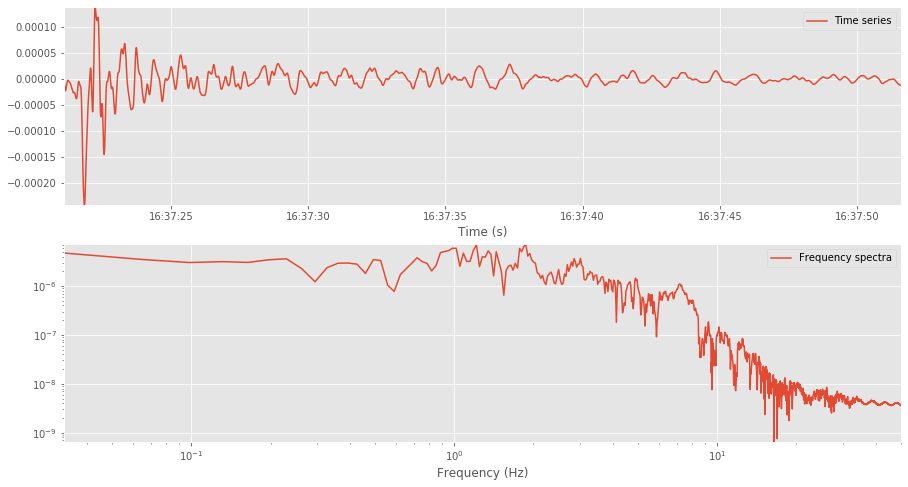

In [9]:
st_disp = st.copy().remove_response(inv, "DISP")
tr = st_disp.select(station="TSZ", component="Z")[0]
s_pick = [p for p in event_picked.picks 
          if p.waveform_id.station_code == tr.stats.station and p.phase_hint == "S"][0]
plot_fft(tr.slice(s_pick.time - 0.5, s_pick.time + 30))

The S-wave displacement spectra (similar for P-wave) has an initially mostly flat portion at low frequencies, 
before the spectral amplitude decays at high frequencies.  From your reading of Stein and Wysession, you should 
know that the moment ($M_0$) is related to the flat portion of the spectra (**at the source**), while the point 
(or points, depending on source model) that the gradient changes are related to source rise and rupture times.  
These points are called *corner frequencies*. We will think more about the Haskell and Brune source models in the 
[source-time function notebook](6_Source_Time_Functions.ipynb). In all models the flat portion of the spectrum is 
related to the moment. For the Haskell model, with two corner frequencies, the **source spectrum** (not the
same as recorded in the far field):
\begin{equation*}
    \log{|A(\omega)|} = 
    \begin{cases}
        \log{M_0} & \omega < 2/T_R \\
        \log{M_0} - \log{(T_R / 2)} - \log{\omega} & 2/T_R < \omega < 2/T_D \\
        \log{M_0} - \log{(T_R T_D / 4)} - 2\log{\omega} & 2/T_D < \omega
    \end{cases}
\end{equation*}
where $\omega$ is frequency, $T_R$ is the rupture time and $T_D$ is the rise time.

Note that the description in Stein and Wysession does not include discussion of estimating seismic moment or
corner frequencies from seismic data. To do this we have to take into account the radiation pattern and
attenuation. If we incorporate this we end up with equation 9.27 from Shearer's "Introduction to Seismology":
\begin{equation*}
    M_0 = \frac{4\pi \rho c^3 r \Omega_0}{U_{\phi\theta}}
\end{equation*}
where $\rho$ is density, $c$ is the wave velocity, $r$ is the distance from the source and $U_{\phi\theta}$ is
a radiation pattern term. This applies for simple spherical wavefronts, but more realistic models can be used
(with complex 3D velocity structures).

If we apply this with an average radiation term (ignoring effects of focal mechanism and directivity) we get:

In [10]:
from math import pi

dist = 34
amp = 10 ** -5
rad = 0.63
density = 2500
c = 3000

M = (4 * pi * density * (c ** 3) * dist * 1e4 * amp) / rad
print("Moment: {0:.4g} Nm".format(M))
expected_moment = 10 ** (1.5 * clean_event.preferred_magnitude().mag + 9.1)
print("Expected Moment: {0:.4g} Nm".format(expected_moment))

Moment: 4.578e+15 Nm
Expected Moment: 1.928e+16 Nm


Which is a lower than expected. One approach is to take an average of moment estimates at different
positions on the focal sphere using this average radiation term (note 0.52 for P and 0.63 for S). However,
a more rigorous option is to compute the full moment tensor.  We will discuss this a little in the 
[next notebook](5_Focal_Mechanisms.ipynb).

## W-phase Moment Magnitude

The W-phase is termed the "whispering" phase.  It occurs as a superposition of body-wave phases. It is now
routinely used to rapidly estimate earthquake magnitude, before the full wavetrain has been recorded. This
makes it very useful for rapid source characterisation and tsumani hazard assessment.  You should read the paper by 
[Duputal et al.](https://academic.oup.com/gji/article/189/2/1125/621962) to familiarise yourself with why this
is used, and how.